### Authentication

In [453]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Data Ingestion

In [454]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

- Resampling every 5 second for each timestep.

In [455]:
temp_df = pd.read_csv('/content/sample_data/test_bigwatcher_data.csv')
temp_df = temp_df.iloc[::5, :] #every 5 sample because of original interval is 1 second
temp_df.reset_index(inplace=True, drop=True)
print("Size of temp data", temp_df.shape)

Size of temp data (36014, 13)


- Device Kit 1

In [456]:
kit1_df_withlabel = temp_df[['KIT1.TEMP','KIT1.HUMI', 'KIT1.POS', 'KIT1.RESULT' ]]
kit1_df = temp_df[['KIT1.TEMP','KIT1.HUMI', 'KIT1.POS']]
kit1_df_withlabel

,KIT1.TEMP,KIT1.HUMI,KIT1.POS,KIT1.RESULT
0,34.786250,45.32500,8,On
1,34.775937,45.31875,8,On
2,34.775937,45.31875,7,On
3,34.652187,45.24375,8,On
4,34.569688,45.19375,8,On
...,...,...,...,...
36009,33.033125,44.26250,12,On
36010,33.022813,44.25625,12,On
36011,33.043438,44.26875,12,On
36012,33.043438,44.26875,12,On


- Device Kit 2

In [457]:
#kit2
kit2_df_withlabel = temp_df[['KIT2.TEMP','KIT2.HUMI', 'KIT2.POS', 'KIT2.RESULT' ]]
kit2_df = temp_df[['KIT2.TEMP','KIT2.HUMI', 'KIT2.POS']]
kit2_df_withlabel

,KIT2.TEMP,KIT2.HUMI,KIT2.POS,KIT2.RESULT
0,34.033437,44.86875,9,On
1,34.043750,44.87500,9,On
2,34.033437,44.86875,9,On
3,34.043750,44.87500,9,On
4,34.064375,44.88750,9,On
...,...,...,...,...
36009,32.960938,44.21875,16,On
36010,32.971250,44.22500,16,On
36011,32.991875,44.23750,16,On
36012,32.991875,44.23750,16,On


#### Label To Numerical

We will consider ```On``` as ```0``` and ```Off``` as ```1``` indicator.

- Device Kit 01

In [458]:
kit1_df_withlabel.loc[demo_df_withlabel['KIT1.RESULT']=='On','LABEL' ] = 0
kit1_df_withlabel.loc[demo_df_withlabel['KIT1.RESULT']=='Off','LABEL' ] = 1

- Device Kit 02

In [459]:
kit2_df_withlabel.loc[test_df_withlabel['KIT2.RESULT']=='On', 'LABEL'] = 0
kit2_df_withlabel.loc[test_df_withlabel['KIT2.RESULT']=='Off', 'LABEL'] = 0

- Relabel with ahead-prediction window.

In [460]:
kit1_df_withlabel['LABEL2']=100
for  i in range (0, kit1_df_withlabel.shape[0], 1):
  if kit1_df_withlabel['LABEL'][i] == 1:
    rul = 0
    kit1_df_withlabel['LABEL2'][i] = rul
    for j in reversed(range(i)):
      if (kit1_df_withlabel['LABEL2'][j] !=1):
        rul = rul +1
        kit1_df_withlabel['LABEL2'][j] = rul
      else:
        break
kit1_df_withlabel

,KIT1.TEMP,KIT1.HUMI,KIT1.POS,KIT1.RESULT,LABEL,LABEL2
0,34.786250,45.32500,8,On,0.0,67
1,34.775937,45.31875,8,On,0.0,66
2,34.775937,45.31875,7,On,0.0,65
3,34.652187,45.24375,8,On,0.0,64
4,34.569688,45.19375,8,On,0.0,63
...,...,...,...,...,...,...
36009,33.033125,44.26250,12,On,0.0,100
36010,33.022813,44.25625,12,On,0.0,100
36011,33.043438,44.26875,12,On,0.0,100
36012,33.043438,44.26875,12,On,0.0,100


In [461]:
#kit2
kit2_df_withlabel['LABEL2']=100
for  i in range (0, kit2_df_withlabel.shape[0], 1):
  if kit2_df_withlabel['LABEL'][i] == 1:
    rul = 0
    kit2_df_withlabel['LABEL2'][i] = rul
    for j in reversed(range(i)):
      if (kit2_df_withlabel['LABEL2'][j] !=1):
        rul = rul +1
        kit2_df_withlabel['LABEL2'][j] = rul
      else:
        break
kit2_df_withlabel

,KIT2.TEMP,KIT2.HUMI,KIT2.POS,KIT2.RESULT,LABEL,LABEL2
0,34.033437,44.86875,9,On,0.0,100
1,34.043750,44.87500,9,On,0.0,100
2,34.033437,44.86875,9,On,0.0,100
3,34.043750,44.87500,9,On,0.0,100
4,34.064375,44.88750,9,On,0.0,100
...,...,...,...,...,...,...
36009,32.960938,44.21875,16,On,0.0,100
36010,32.971250,44.22500,16,On,0.0,100
36011,32.991875,44.23750,16,On,0.0,100
36012,32.991875,44.23750,16,On,0.0,100


#### Rolling With Window = ```30 seconds```

Because of resolution is every 5 second for each timestep. To rolling window on timeseries data we need configure ```rolling window``` of ```6``` timestep = 30 seconds of lag.

In [462]:
win1 = 6

- Mean property

In [463]:
rolling_win = win1
kit1_rolling_mean1 = kit1_df.rolling(rolling_win).mean()
kit1_rolling_mean1.rename(columns={"KIT1.TEMP":"TEMP_MEAN"+str(rolling_win), 
                              "KIT1.HUMI": "HUMI_MEAN"+str(rolling_win), 
                              "KIT1.POS": "POS_MEAN"+str(rolling_win)}, inplace = True)

- Standard property

In [464]:
rolling_win = win1
kit1_rolling_std1 = kit1_df.rolling(rolling_win).std()
kit1_rolling_std1.rename(columns={"KIT1.TEMP":"TEMP_STD"+str(rolling_win), 
                             "KIT1.HUMI": "HUMI_STD"+str(rolling_win), 
                             "KIT1.POS": "POS_STD"+str(rolling_win)}, inplace=True)

- Mean property

In [465]:
#kit2
rolling_win = win1
kit2_rolling_mean1 = kit2_df.rolling(rolling_win).mean()
kit2_rolling_mean1.rename(columns={"KIT2.TEMP":"TEMP_MEAN"+str(rolling_win), 
                              "KIT2.HUMI": "HUMI_MEAN"+str(rolling_win), 
                              "KIT2.POS": "POS_MEAN"+str(rolling_win)}, inplace = True)

- Standard property

In [466]:
#kit2
rolling_win = win1
kit2_testing_rolling_std1 = kit2_df.rolling(rolling_win).std()
kit2_testing_rolling_std1.rename(columns={"KIT2.TEMP":"TEMP_STD"+str(rolling_win), 
                             "KIT2.HUMI": "HUMI_STD"+str(rolling_win), 
                             "KIT2.POS": "POS_STD"+str(rolling_win)}, inplace=True)

#### Rolling With Window = ```1 minutes```

Because of resolution is every 5 second for each timestep. To rolling window on timeseries data we need configure ```rolling window``` of ```12``` timestep = 60 seconds of lag.

In [467]:
win2 = 12

- Mean property

In [468]:
rolling_win = win2
kit1_rolling_mean2 = kit1_df.rolling(rolling_win).mean()
kit1_rolling_mean2.rename(columns={"KIT1.TEMP":"TEMP_MEAN"+str(rolling_win),
                              "KIT1.HUMI": "HUMI_MEAN"+str(rolling_win), 
                              "KIT1.POS": "POS_MEAN"+str(rolling_win)}, inplace=True)

- Standard property

In [469]:
rolling_win = win2
kit1_rolling_std2 = kit1_df.rolling(rolling_win).std()
kit1_rolling_std2.rename(columns={"KIT1.TEMP":"TEMP_STD"+str(rolling_win), 
                             "KIT1.HUMI": "HUMI_STD"+str(rolling_win), 
                             "KIT1.POS": "POS_STD"+str(rolling_win)}, inplace=True)

- Mean property

In [470]:
#testing
rolling_win = win2
kit2_rolling_mean2 = kit2_df.rolling(rolling_win).mean()
kit2_rolling_mean2.rename(columns={"KIT2.TEMP":"TEMP_MEAN"+str(rolling_win),
                              "KIT2.HUMI": "HUMI_MEAN"+str(rolling_win), 
                              "KIT2.POS": "POS_MEAN"+str(rolling_win)}, inplace=True)

- Standard property

In [471]:
#testing
rolling_win = win2
kit2_rolling_std2 = kit2_df.rolling(rolling_win).std()
kit2_rolling_std2.rename(columns={"KIT2.TEMP":"TEMP_STD"+str(rolling_win), 
                             "KIT2.HUMI": "HUMI_STD"+str(rolling_win), 
                             "KIT2.POS": "POS_STD"+str(rolling_win)}, inplace=True)

#### Rolling Concatenate Of Kit 1

In [472]:
kit1_rolling_concat = pd.concat([kit1_rolling_mean1, kit1_rolling_std1, kit1_rolling_mean2, kit1_rolling_std2], axis=1, )
kit1_rolling_concat

,TEMP_MEAN6,HUMI_MEAN6,POS_MEAN6,TEMP_STD6,HUMI_STD6,POS_STD6,TEMP_MEAN12,HUMI_MEAN12,POS_MEAN12,TEMP_STD12,HUMI_STD12,POS_STD12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
36009,33.019375,44.254167,12.0,0.010651,0.006455,2.064765e-07,33.012500,44.250000,12.0,0.011634,0.007051,0.0
36010,33.021094,44.255208,12.0,0.010139,0.006145,2.064765e-07,33.015078,44.251562,12.0,0.009955,0.006033,0.0
36011,33.024531,44.257292,12.0,0.013707,0.008307,2.064765e-07,33.017656,44.253125,12.0,0.012820,0.007770,0.0
36012,33.031406,44.261458,12.0,0.010139,0.006145,2.064765e-07,33.021094,44.255208,12.0,0.013789,0.008357,0.0


#### Rolling Concatenate Of Kit 2

In [473]:
#kit 2
kit2_rolling_concat = pd.concat([kit2_rolling_mean1, kit2_rolling_std1, kit2_rolling_mean2, kit2_rolling_std2], axis=1, )
kit2_rolling_concat

,TEMP_MEAN6,HUMI_MEAN6,POS_MEAN6,TEMP_STD6,HUMI_STD6,POS_STD6,TEMP_MEAN12,HUMI_MEAN12,POS_MEAN12,TEMP_STD12,HUMI_STD12,POS_STD12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
36009,32.960938,44.218750,16.0,0.010651,0.006455,2.064765e-07,32.954063,44.214583,16.0,0.012694,0.007693,0.0
36010,32.962656,44.219792,16.0,0.010139,0.006145,2.064765e-07,32.957500,44.216667,16.0,0.011066,0.006707,0.0
36011,32.967813,44.222917,16.0,0.013707,0.008307,2.064765e-07,32.962656,44.219792,16.0,0.011495,0.006967,0.0
36012,32.972969,44.226042,16.0,0.010139,0.006145,2.064765e-07,32.966094,44.221875,16.0,0.013553,0.008214,0.0


#### Normalization Dataframe

In [474]:
from sklearn import  preprocessing

In [475]:
minmax_scaler = preprocessing.MinMaxScaler();
scaled = minmax_scaler.fit_transform(kit1_rolling_concat.values)
kit1_norm_rolling_concat = pd.DataFrame(scaled)
kit1_norm_rolling_concat.columns = rolling_concat.columns
kit1_norm_rolling_concat

,TEMP_MEAN6,HUMI_MEAN6,POS_MEAN6,TEMP_STD6,HUMI_STD6,POS_STD6,TEMP_MEAN12,HUMI_MEAN12,POS_MEAN12,TEMP_STD12,HUMI_STD12,POS_STD12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
36009,0.436203,0.436203,0.75,0.002921,0.002921,2.618737e-08,0.436111,0.436111,0.75,0.003578,0.003578,0.0
36010,0.436263,0.436263,0.75,0.002780,0.002780,2.618737e-08,0.436202,0.436202,0.75,0.003061,0.003061,0.0
36011,0.436385,0.436385,0.75,0.003759,0.003759,2.618737e-08,0.436293,0.436293,0.75,0.003943,0.003943,0.0
36012,0.436627,0.436627,0.75,0.002780,0.002780,2.618737e-08,0.436414,0.436414,0.75,0.004241,0.004241,0.0


In [476]:
#testing
kit2_scaled = minmax_scaler.transform(kit2_rolling_concat.values)
kit2_norm_rolling_concat = pd.DataFrame(kit2_scaled)
kit2_norm_rolling_concat.columns = kit2_rolling_concat.columns
kit2_norm_rolling_concat

,TEMP_MEAN6,HUMI_MEAN6,POS_MEAN6,TEMP_STD6,HUMI_STD6,POS_STD6,TEMP_MEAN12,HUMI_MEAN12,POS_MEAN12,TEMP_STD12,HUMI_STD12,POS_STD12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
36009,0.434139,0.434139,1.0,0.002921,0.002921,2.618737e-08,0.434046,0.434046,1.0,0.003904,0.003904,0.0
36010,0.434199,0.434199,1.0,0.002780,0.002780,2.618737e-08,0.434167,0.434167,1.0,0.003403,0.003403,0.0
36011,0.434381,0.434381,1.0,0.003759,0.003759,2.618737e-08,0.434350,0.434350,1.0,0.003535,0.003535,0.0
36012,0.434564,0.434564,1.0,0.002780,0.002780,2.618737e-08,0.434471,0.434471,1.0,0.004168,0.004168,0.0


#### Label With Window = 12 ~ ```1 Minutes```

- Device Kit 1

In [477]:
win_predict = 12
kit1_df_withlabel['LABEL3']=0
kit1_df_withlabel.loc[kit1_df_withlabel['LABEL2'] <= win_predict , 'LABEL3'] = 1
kit1_df_withlabel.loc[kit1_df_withlabel['LABEL2'] > win_predict, 'LABEL3'] = 0
kit1_df_withlabel

,KIT1.TEMP,KIT1.HUMI,KIT1.POS,KIT1.RESULT,LABEL,LABEL2,LABEL3
0,34.786250,45.32500,8,On,0.0,67,0
1,34.775937,45.31875,8,On,0.0,66,0
2,34.775937,45.31875,7,On,0.0,65,0
3,34.652187,45.24375,8,On,0.0,64,0
4,34.569688,45.19375,8,On,0.0,63,0
...,...,...,...,...,...,...,...
36009,33.033125,44.26250,12,On,0.0,100,0
36010,33.022813,44.25625,12,On,0.0,100,0
36011,33.043438,44.26875,12,On,0.0,100,0
36012,33.043438,44.26875,12,On,0.0,100,0


- Device Kit 02

In [478]:
# kit 2
win_predict = 12
kit2_df_withlabel['LABEL3']=0
kit2_df_withlabel.loc[kit2_df_withlabel['LABEL2'] <= win_predict , 'LABEL3'] = 1
kit2_df_withlabel.loc[kit2_df_withlabel['LABEL2'] > win_predict, 'LABEL3'] = 0
kit2_df_withlabel

,KIT2.TEMP,KIT2.HUMI,KIT2.POS,KIT2.RESULT,LABEL,LABEL2,LABEL3
0,34.033437,44.86875,9,On,0.0,100,0
1,34.043750,44.87500,9,On,0.0,100,0
2,34.033437,44.86875,9,On,0.0,100,0
3,34.043750,44.87500,9,On,0.0,100,0
4,34.064375,44.88750,9,On,0.0,100,0
...,...,...,...,...,...,...,...
36009,32.960938,44.21875,16,On,0.0,100,0
36010,32.971250,44.22500,16,On,0.0,100,0
36011,32.991875,44.23750,16,On,0.0,100,0
36012,32.991875,44.23750,16,On,0.0,100,0


In [479]:
label = kit1_df_withlabel['LABEL3']

In [480]:
kit1_full_df = pd.concat([kit1_norm_rolling_concat, label], axis =1)
kit1_full_df.shape
kit1_full_df['id'] = 1
kit1_full_df

,TEMP_MEAN6,HUMI_MEAN6,POS_MEAN6,TEMP_STD6,HUMI_STD6,POS_STD6,TEMP_MEAN12,HUMI_MEAN12,POS_MEAN12,TEMP_STD12,HUMI_STD12,POS_STD12,LABEL3,id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36009,0.436203,0.436203,0.75,0.002921,0.002921,2.618737e-08,0.436111,0.436111,0.75,0.003578,0.003578,0.0,0,1
36010,0.436263,0.436263,0.75,0.002780,0.002780,2.618737e-08,0.436202,0.436202,0.75,0.003061,0.003061,0.0,0,1
36011,0.436385,0.436385,0.75,0.003759,0.003759,2.618737e-08,0.436293,0.436293,0.75,0.003943,0.003943,0.0,0,1
36012,0.436627,0.436627,0.75,0.002780,0.002780,2.618737e-08,0.436414,0.436414,0.75,0.004241,0.004241,0.0,0,1


In [481]:
#kit2
kit2_full_df = pd.concat([kit2_norm_rolling_concat, label], axis =1)
kit2_full_df.shape
kit2_full_df['id'] = 1
kit2_full_df

,TEMP_MEAN6,HUMI_MEAN6,POS_MEAN6,TEMP_STD6,HUMI_STD6,POS_STD6,TEMP_MEAN12,HUMI_MEAN12,POS_MEAN12,TEMP_STD12,HUMI_STD12,POS_STD12,LABEL3,id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36009,0.434139,0.434139,1.0,0.002921,0.002921,2.618737e-08,0.434046,0.434046,1.0,0.003904,0.003904,0.0,0,1
36010,0.434199,0.434199,1.0,0.002780,0.002780,2.618737e-08,0.434167,0.434167,1.0,0.003403,0.003403,0.0,0,1
36011,0.434381,0.434381,1.0,0.003759,0.003759,2.618737e-08,0.434350,0.434350,1.0,0.003535,0.003535,0.0,0,1
36012,0.434564,0.434564,1.0,0.002780,0.002780,2.618737e-08,0.434471,0.434471,1.0,0.004168,0.004168,0.0,0,1


#### Delete Nan Values From Data Frame

In [482]:
kit1_full_df = kit1_full_df.loc[12:full_df.shape[0],:]
kit1_full_df.reset_index(inplace=True, drop=True)
kit1_full_df

,TEMP_MEAN6,HUMI_MEAN6,POS_MEAN6,TEMP_STD6,HUMI_STD6,POS_STD6,TEMP_MEAN12,HUMI_MEAN12,POS_MEAN12,TEMP_STD12,HUMI_STD12,POS_STD12,LABEL3,id
0,0.464125,0.464125,0.666667,0.090526,0.090526,5.239569e-01,0.478197,0.478197,0.578125,0.148098,0.148098,0.412267,0,1
1,0.457570,0.457570,0.750000,0.098448,0.098448,5.557402e-01,0.473309,0.473309,0.619792,0.165283,0.165283,0.479138,0,1
2,0.450832,0.450832,0.833333,0.104711,0.104711,5.239569e-01,0.467843,0.467843,0.666667,0.178297,0.178297,0.512936,0,1
3,0.443669,0.443669,0.916667,0.109986,0.109986,4.142243e-01,0.462073,0.462073,0.708333,0.192509,0.192509,0.536442,0,1
4,0.435717,0.435717,1.000000,0.116912,0.116912,0.000000e+00,0.455697,0.455697,0.750000,0.208318,0.208318,0.544051,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35986,0.435595,0.435595,0.750000,0.003577,0.003577,2.618737e-08,0.435291,0.435291,0.750000,0.005259,0.005259,0.000000,0,1
35987,0.435778,0.435778,0.750000,0.002366,0.002366,2.618737e-08,0.435382,0.435382,0.750000,0.005576,0.005576,0.000000,0,1
35988,0.435778,0.435778,0.750000,0.002366,0.002366,2.618737e-08,0.435443,0.435443,0.750000,0.005548,0.005548,0.000000,0,1
35989,0.435778,0.435778,0.750000,0.002366,0.002366,2.618737e-08,0.435595,0.435595,0.750000,0.004773,0.004773,0.000000,0,1


In [483]:
#kit 2
kit2_full_df = kit2_full_df.loc[12:test_full_df.shape[0],:]
kit2_full_df.reset_index(inplace=True, drop=True)
kit2_full_df

,TEMP_MEAN6,HUMI_MEAN6,POS_MEAN6,TEMP_STD6,HUMI_STD6,POS_STD6,TEMP_MEAN12,HUMI_MEAN12,POS_MEAN12,TEMP_STD12,HUMI_STD12,POS_STD12,LABEL3,id
0,0.472441,0.472441,0.562500,0.090526,0.090526,5.239569e-01,0.472549,0.472549,0.562500,0.003578,0.003578,0.000000,0,1
1,0.472320,0.472320,0.531250,0.098448,0.098448,5.557402e-01,0.472519,0.472519,0.546875,0.003693,0.003693,0.112776,0,1
2,0.471956,0.471956,0.604167,0.104711,0.104711,5.239569e-01,0.472367,0.472367,0.583333,0.006556,0.006556,0.295565,0,1
3,0.471167,0.471167,0.625000,0.109986,0.109986,4.142243e-01,0.471942,0.471942,0.593750,0.013945,0.013945,0.301589,0,1
4,0.470013,0.470013,0.645833,0.116912,0.116912,0.000000e+00,0.471274,0.471274,0.604167,0.021275,0.021275,0.305819,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35986,0.432621,0.432621,1.000000,0.003577,0.003577,2.618737e-08,0.432376,0.432376,1.000000,0.004511,0.004511,0.000000,0,1
35987,0.432682,0.432682,1.000000,0.002366,0.002366,2.618737e-08,0.432497,0.432497,1.000000,0.004578,0.004578,0.000000,0,1
35988,0.432925,0.432925,1.000000,0.002366,0.002366,2.618737e-08,0.432649,0.432649,1.000000,0.005657,0.005657,0.000000,0,1
35989,0.433167,0.433167,1.000000,0.002366,0.002366,2.618737e-08,0.432831,0.432831,1.000000,0.005895,0.005895,0.000000,0,1


#### Save final Temp_data to CSV

In [484]:
from google.colab import files
kit1_full_df.to_csv('TempPdmFinalKit1.csv')
kit2_full_df.to_csv('TempPdmFinalKit2.csv')

### Training Data Frame


In [485]:
#define function generate sequence
def gen_sequence(id_df,seq_length, seq_cols):
  data_matrix = id_df[seq_cols].values
  num_elements = data_matrix.shape[0]
  #print(data_matrix)
  print("number of elements of current machine ID: "+ str(num_elements))
  for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
    yield data_matrix[start:stop, :]

- Device Kit 1

In [486]:
#identity the name of column
sequence_length = 36
sequence_cols = kit1_full_df.columns.drop(['LABEL3','id']) 

#generate sequence
kit1_seq_gen = (list(gen_sequence(kit1_full_df[kit1_full_df.id==id], sequence_length, sequence_cols)) for id in kit1_full_df.id.unique())

#generate array
kit1_seq_array = np.concatenate(list(kit1_seq_gen)).astype(np.float32)
kit1_seq_array.shape

number of elements of current machine ID: 35991


(35955, 36, 12)

- Device Kit 2

In [487]:
#kit 2
sequence_cols = kit2_full_df.columns.drop(['LABEL3','id']) 
#generate sequence
kit2_seq_gen = (list(gen_sequence(kit2_full_df[kit2_full_df.id==id], sequence_length, sequence_cols)) for id in kit2_full_df.id.unique())

#generate array
kit2_seq_array = np.concatenate(list(kit2_seq_gen)).astype(np.float32)
kit2_seq_array.shape

number of elements of current machine ID: 35991


(35955, 36, 12)

In [488]:
# function to generate labels
def generate_labels(id_df, seq_length, label):
  data_matrix = id_df[label].values
  num_elements = data_matrix.shape[0]
  return data_matrix[seq_length:num_elements, :]

sequence_length = 36
label_cols = ['LABEL3']
kit1_label_gen = [generate_labels(kit1_full_df[full_df.id==id], sequence_length, label_cols) 
             for id in kit1_full_df.id.unique()]

kit1_label_array = np.concatenate(kit1_label_gen).astype(np.float32)

kit1_binary_label_array= np.array([])
for x in range(len(kit1_label_array)): 
    if (kit1_label_array[x] == [0]):
      a =np.array( [1 , 0 ])
      kit1_binary_label_array = np.concatenate((kit1_binary_label_array, a)).astype(np.float32)
    if (kit1_label_array[x] == [1]):
      a = np.array( [0 , 1 ])
      kit1_binary_label_array=np.concatenate((kit1_binary_label_array, a)).astype(np.float32)

kit1_binary_label_array= kit1_binary_label_array.reshape(-1,2)
kit1_binary_label_array.shape

(35955, 2)

In [489]:
#kit 2
kit2_label_gen = [generate_labels(kit2_full_df[kit2_full_df.id==id], sequence_length, label_cols) 
             for id in kit2_full_df.id.unique()]

kit2_label_array = np.concatenate(kit2_label_gen).astype(np.float32)

kit2_binary_label_array= np.array([])
for x in range(len(kit2_label_array)): 
    if (kit2_label_array[x] == [0]):
      a =np.array( [1 , 0 ])
      kit2_binary_label_array = np.concatenate((kit2_binary_label_array, a)).astype(np.float32)
    if (kit2_label_array[x] == [1]):
      a = np.array( [0 , 1 ])
      kit2_binary_label_array=np.concatenate((kit2_binary_label_array, a)).astype(np.float32)

kit2_binary_label_array= kit2_binary_label_array.reshape(-1,2)
kit2_binary_label_array.shape

(35955, 2)

### Predictive Maintenance Model

#### MLP based Predictive Miantenance

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 432)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                27712     
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 130       
Total params: 27,842
Trainable params: 27,842
Non-trainable params: 0
_________________________________________________________________


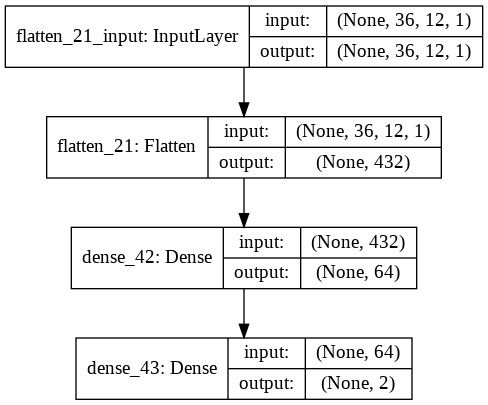

In [490]:
from keras.models import Sequential
from keras.layers import  Dense
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

#Information about 
sequence_length = 36  #number of sequence
nb_features = 12      #number of features
nb_out = 2            #number of output (2 for binary, >2 for multi-classifier)

#MLP based model
mlp_model = Sequential();
mlp_model.add(Flatten(input_shape=(sequence_length, nb_features, 1)))
mlp_model.add(Dense(units=64, activation='linear'))
mlp_model.add(Dense(units=nb_out, activation='softmax'))

mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Visualization
mlp_model.summary()
plot_model(mlp_model, to_file='mlp_model_plot.png', show_shapes=True, show_layer_names=True)

#### LSTM based Predictive Maintenance

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 36, 12)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 36, 16)            1856      
_________________________________________________________________
lstm_35 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 66        
Total params: 8,194
Trainable params: 8,194
Non-trainable params: 0
_________________________________________________________________


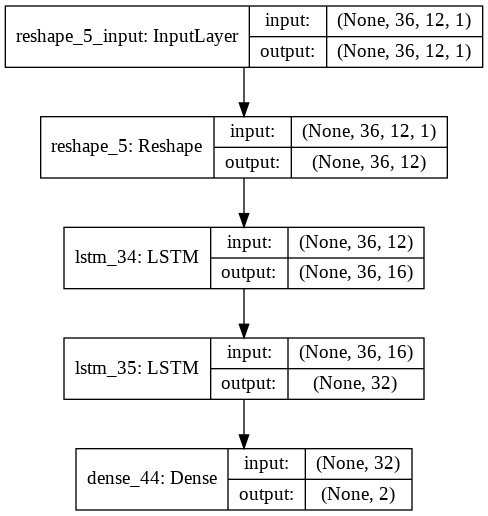

In [491]:
import keras
import pandas
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Reshape
from keras.utils.vis_utils import plot_model


#Information about 
sequence_length = 36  #number of sequence
nb_features = 12      #number of features
nb_out = 2            #number of output (2 for binary, >2 for multi-classifier)

#RNN based model
lstmModel = Sequential()
lstmModel.add(Reshape(input_shape=(sequence_length, nb_features, 1),
                      target_shape=(sequence_length, nb_features)))
lstmModel.add(LSTM(input_shape=(sequence_length, nb_features),
                     units=16,
                     return_sequences=True))
#lstmModel.add(Dropout(0.2)) #add this for avoiding overfitting
lstmModel.add(LSTM(input_shape=(sequence_length, nb_features),
                     units=32,
                     return_sequences=False))
#lstmModel.add(Dropout(0.2)) #add this for avoiding overfitting
lstmModel.add(Dense(units=nb_out, activation='softmax'))
lstmModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Visualization
lstmModel.summary()
plot_model(lstmModel, to_file='lstmModel.png', show_shapes=True, show_layer_names=True)


#### CNN based Predictive Maintenance

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 18, 6, 8)          80        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 9, 3, 8)           0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 2, 16)          1168      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 2, 1, 16)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 66        
Total params: 1,314
Trainable params: 1,314
Non-trainable params: 0
___________________________________________________

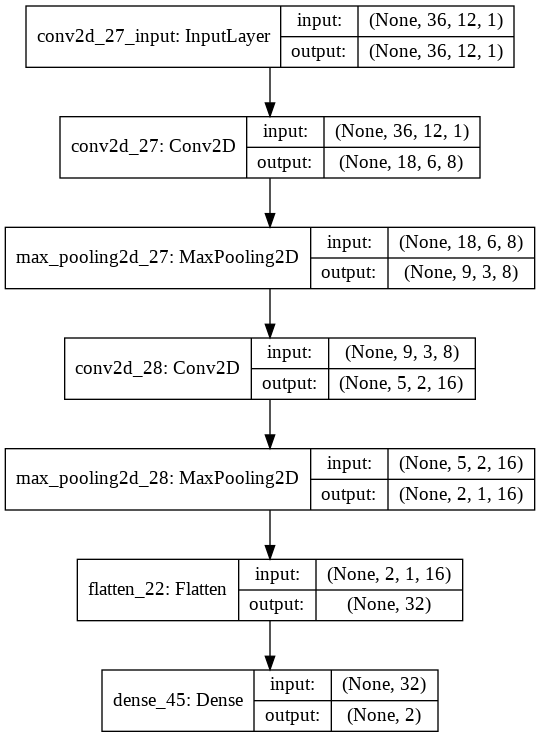

In [492]:
from keras.models import Sequential
from keras.layers import  Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import  Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

#Information about 
sequence_length = 36  #number of sequence
nb_features = 12      #number of features
nb_out = 2            #number of output (2 for binary, >2 for multi-classifier)

#CNN based model
cnn_model = Sequential();
cnn_model.add(Conv2D( filters=8, kernel_size=(3,3), strides=(2,2),padding='Same', use_bias=True, 
                     input_shape=(sequence_length,nb_features,1)))
cnn_model.add(MaxPool2D(pool_size=(2,2), strides=2))
#cnn_model.add(Dropout(0.2)) #add this for avoiding overfitting
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', strides=(2,2), use_bias=True))
cnn_model.add(MaxPool2D(pool_size=(2,2), strides=2))
#cnn_model.add(Dropout(0.2)) #add this for avoiding overfitting
cnn_model.add(Flatten())
cnn_model.add(Dense(units=nb_out, activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Visualization
cnn_model.summary()
plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Split Dataset Into Training Set (Train+Vali) and Testing Set

In [493]:
from sklearn.model_selection import train_test_split
# Select Device Kit
seq_array = kit1_seq_array
binary_label_array = kit1_binary_label_array

#general
seq_array = seq_array.reshape(seq_array.shape[0], seq_array.shape[1], seq_array.shape[2], 1)
X_train, X_test, y_train, y_test = train_test_split( seq_array, binary_label_array, test_size=0.2, random_state=2)

In [494]:
print("Training shape: ", X_train.shape)
print(X_train.shape[0] , " training samples")
print(X_test.shape[0] , " testing samples")

Training shape:  (28764, 36, 12, 1)
28764  training samples
7191  testing samples


#### Training Processing

In [495]:
mlp_history = mlp_model.fit(X_train, y_train, epochs=100, batch_size=200, validation_split=0.10, verbose=1)

Train on 25887 samples, validate on 2877 samples
Epoch 1/100
25887/25887 [==============================] - 0s 17us/step - loss: 0.3807 - accuracy: 0.8759 - val_loss: 0.3168 - val_accuracy: 0.8947
Epoch 2/100
25887/25887 [==============================] - 0s 15us/step - loss: 0.3304 - accuracy: 0.8857 - val_loss: 0.3177 - val_accuracy: 0.8964
Epoch 3/100
25887/25887 [==============================] - 0s 14us/step - loss: 0.3292 - accuracy: 0.8864 - val_loss: 0.3167 - val_accuracy: 0.8982
Epoch 4/100
25887/25887 [==============================] - 0s 15us/step - loss: 0.3301 - accuracy: 0.8872 - val_loss: 0.3155 - val_accuracy: 0.8954
Epoch 5/100
25887/25887 [==============================] - 0s 15us/step - loss: 0.3279 - accuracy: 0.8872 - val_loss: 0.3262 - val_accuracy: 0.9006
Epoch 6/100
25887/25887 [==============================] - 0s 14us/step - loss: 0.3328 - accuracy: 0.8867 - val_loss: 0.3205 - val_accuracy: 0.9006
Epoch 7/100
25887/25887 [==============================] - 0s 1

#### LSTM model

In [496]:
lstm_history = lstmModel.fit(X_train, y_train, batch_size=200, epochs=50, validation_split=0.10, verbose=1)

Train on 25887 samples, validate on 2877 samples
Epoch 1/50
25887/25887 [==============================] - 16s 621us/step - loss: 0.2617 - accuracy: 0.9163 - val_loss: 0.1456 - val_accuracy: 0.9642
Epoch 2/50
25887/25887 [==============================] - 15s 589us/step - loss: 0.0617 - accuracy: 0.9820 - val_loss: 0.0390 - val_accuracy: 0.9871
Epoch 3/50
25887/25887 [==============================] - 15s 598us/step - loss: 0.0368 - accuracy: 0.9878 - val_loss: 0.0278 - val_accuracy: 0.9896
Epoch 4/50
25887/25887 [==============================] - 15s 594us/step - loss: 0.0299 - accuracy: 0.9896 - val_loss: 0.0385 - val_accuracy: 0.9871
Epoch 5/50
25887/25887 [==============================] - 15s 598us/step - loss: 0.0262 - accuracy: 0.9903 - val_loss: 0.0208 - val_accuracy: 0.9930
Epoch 6/50
25887/25887 [==============================] - 15s 592us/step - loss: 0.0226 - accuracy: 0.9926 - val_loss: 0.0207 - val_accuracy: 0.9934
Epoch 7/50
25887/25887 [==============================] -

#### CNN Model

In [497]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=200, validation_split=0.10, verbose=1)

Train on 25887 samples, validate on 2877 samples
Epoch 1/100
25887/25887 [==============================] - 1s 22us/step - loss: 0.3740 - accuracy: 0.8574 - val_loss: 0.2558 - val_accuracy: 0.8933
Epoch 2/100
25887/25887 [==============================] - 0s 18us/step - loss: 0.1474 - accuracy: 0.9402 - val_loss: 0.0645 - val_accuracy: 0.9788
Epoch 3/100
25887/25887 [==============================] - 0s 18us/step - loss: 0.0617 - accuracy: 0.9798 - val_loss: 0.0488 - val_accuracy: 0.9826
Epoch 4/100
25887/25887 [==============================] - 0s 18us/step - loss: 0.0548 - accuracy: 0.9827 - val_loss: 0.0446 - val_accuracy: 0.9854
Epoch 5/100
25887/25887 [==============================] - 0s 18us/step - loss: 0.0513 - accuracy: 0.9838 - val_loss: 0.0428 - val_accuracy: 0.9844
Epoch 6/100
25887/25887 [==============================] - 0s 18us/step - loss: 0.0488 - accuracy: 0.9846 - val_loss: 0.0414 - val_accuracy: 0.9868
Epoch 7/100
25887/25887 [==============================] - 0s 1

### Evaluation Predictor

#### MLP Model

- Training Phase

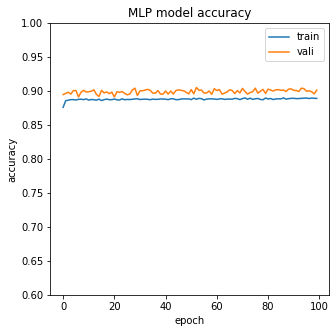

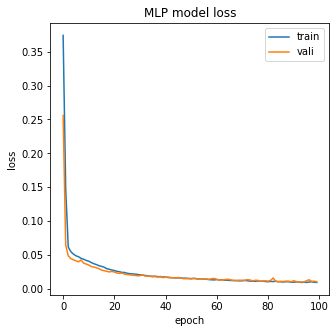

In [498]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.title('MLP model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.6, 1)
plt.legend(['train', 'vali'], loc='best')
plt.show()
fig_acc.savefig("mlp_Model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('MLP model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vali'], loc='best')
plt.show()
fig_acc.savefig("mlp_Model_loss.png")

In [499]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.utils import to_categorical

# training metrics
scores = mlp_model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = mlp_model.predict_classes(X_train, verbose=1, batch_size=200)
y_true = [np.argmax(x) for x in y_train]
print('Training confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

28764/28764 [==============================] - 0s 10us/step
Accurracy: 0.8934431672096252
28764/28764 [==============================] - 0s 5us/step
Training confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[25029   386]
 [ 2679   670]]
precision =  0.634469696969697 
 recall =  0.20005971931919977


- Testing Phase

In [500]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.utils import to_categorical

# training metrics
scores = mlp_model.evaluate(X_test, y_test, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = mlp_model.predict_classes(X_test, verbose=1, batch_size=200)
y_true = [np.argmax(x) for x in y_test]
print('Training confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

7191/7191 [==============================] - 0s 10us/step
Accurracy: 0.8873592019081116
7191/7191 [==============================] - 0s 5us/step
Training confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[6209  118]
 [ 692  172]]
precision =  0.593103448275862 
 recall =  0.19907407407407407


#### LSTM Model

- Training Phase

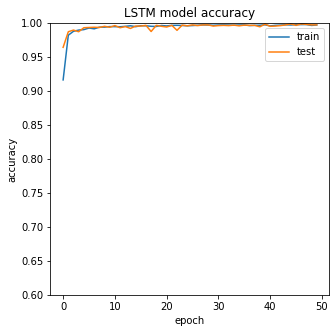

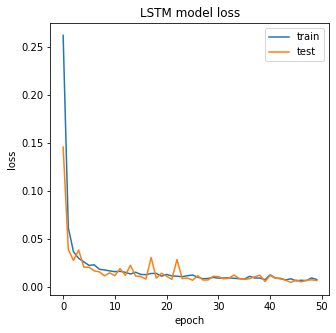

In [501]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.6, 1)
plt.legend(['train', 'test'], loc='best')
plt.show()
fig_acc.savefig("lstmModel_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
fig_acc.savefig("lstmModel_loss.png")

In [502]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.utils import to_categorical

# training metrics
scores = lstmModel.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = lstmModel.predict_classes(X_train, verbose=1, batch_size=200)
y_true = [np.argmax(x) for x in y_train]
print('Training confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

28764/28764 [==============================] - 2s 55us/step
Accurracy: 0.9973230361938477
28764/28764 [==============================] - 2s 55us/step
Training confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[25354    61]
 [   16  3333]]
precision =  0.9820271066588097 
 recall =  0.9952224544640191


- Testing Phase

In [503]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.utils import to_categorical

# training metrics
scores = lstmModel.evaluate(X_test, y_test, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = lstmModel.predict_classes(X_test, verbose=1, batch_size=200)
y_true = [np.argmax(x) for x in y_test]
print('Training confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

7191/7191 [==============================] - 0s 57us/step
Accurracy: 0.9974968433380127
7191/7191 [==============================] - 0s 51us/step
Training confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[6316   11]
 [   7  857]]
precision =  0.9873271889400922 
 recall =  0.9918981481481481


#### CNN Model

- Training Phase

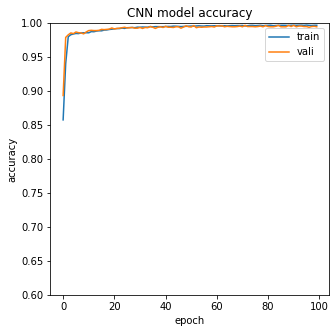

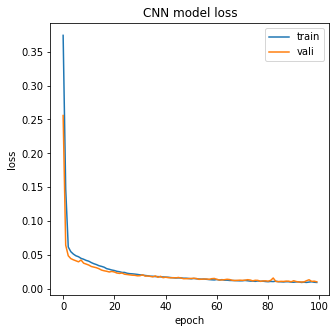

In [504]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.6, 1)
plt.legend(['train', 'vali'], loc='best')
plt.show()
fig_acc.savefig("lstmModel_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vali'], loc='best')
plt.show()
fig_acc.savefig("cnnModel_loss.png")

In [505]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.utils import to_categorical

# training metrics
scores = cnn_model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = cnn_model.predict_classes(X_train, verbose=1, batch_size=200)
y_true = [np.argmax(x) for x in y_train]
print('Training confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

28764/28764 [==============================] - 0s 10us/step
Accurracy: 0.9969058632850647
28764/28764 [==============================] - 0s 7us/step
Training confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[25365    50]
 [   39  3310]]
precision =  0.9851190476190477 
 recall =  0.9883547327560466


- Testing Phase

In [506]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.utils import to_categorical

# training metrics
scores = cnn_model.evaluate(X_test, y_test, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = cnn_model.predict_classes(X_test, verbose=1, batch_size=200)
y_true = [np.argmax(x) for x in y_test]
print('Training confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

7191/7191 [==============================] - 0s 10us/step
Accurracy: 0.9961062669754028
7191/7191 [==============================] - 0s 6us/step
Training confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[6316   11]
 [  17  847]]
precision =  0.9871794871794872 
 recall =  0.9803240740740741
